# Algorithm for dog breed identification

--- 

the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  

### The notebook

The notebook is broken down into separate steps.
* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
from PIL import Image
import torchvision.transforms as transforms
from PIL import ImageFile
import torch
import torchvision.models as models

import os
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from glob import glob

import random

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline         

In [1]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

NameError: name 'torch' is not defined

In [9]:
random.seed(12)

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))
random.shuffle(human_files)

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [10]:
human_files

array(['/data/lfw/Eli_Broad/Eli_Broad_0001.jpg',
       '/data/lfw/John_Bolton/John_Bolton_0004.jpg',
       '/data/lfw/Jennifer_Rodriguez/Jennifer_Rodriguez_0002.jpg', ...,
       '/data/lfw/Eloy_Gutierrez/Eloy_Gutierrez_0001.jpg',
       '/data/lfw/Amer_al-Saadi/Amer_al-Saadi_0003.jpg',
       '/data/lfw/Darren_Clarke/Darren_Clarke_0001.jpg'], 
      dtype='<U90')

In [11]:
breeds = [x.split('/')[4][4:] for x in dog_files]
breeds = np.unique(breeds)
print(f"There are {len(breeds)} breeds in total")
print(f"example breeds: {breeds[:5]}")

There are 133 breeds in total
example breeds: ['Affenpinscher' 'Afghan_hound' 'Airedale_terrier' 'Akita'
 'Alaskan_malamute']


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


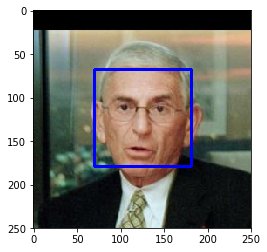

In [4]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [11]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)  # read image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #c onvert to grey
    faces = face_cascade.detectMultiScale(gray)  # detect faces
    return len(faces) > 0  # if faces empty, no face found (return False). If non-empty return True.

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [4]:
# from tqdm import tqdm

In [13]:
# pick some human and dog files to test our face detector on
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

# Test the performance of the face_detector algorithm 
human_count = 0
dog_count = 0

for ii, human_path in enumerate(human_files_short):
    human_count += face_detector(human_path)
    dog_count += face_detector(dog_files_short[ii])
    
print(f'Faces were detected in {human_count}% of our human images, and {dog_count}% of our dog images')

Faces were detected in 99% of our human images, and 17% of our dog images


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [14]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 85067966.78it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path, model):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: string, path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # select the image    
    im = Image.open(img_path).convert('RGB')
    
    
    # crop images to correct size (224x224 for vgg16), transform to tensor and normalize
    data_transform = transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])
    image = data_transform(im)
    
    # include batch size dimension
    image.unsqueeze_(0)
    if use_cuda:
        image = image.to('cuda')
    # get prediction and select most likely class
    outcome = model.forward(image)
    max_index = torch.max(outcome, 1)[1].item()
    
    return max_index # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, model):
    ## TODO: Complete the function.
    
    predicted_idx = VGG16_predict(img_path, model)
    return predicted_idx <= 268 and predicted_idx >= 151

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

See output of cell below

In [17]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_count = 0
dog_count = 0

for ii, human_path in enumerate(human_files_short):
    human_count += dog_detector(human_path, VGG16)
    dog_count += dog_detector(dog_files_short[ii], VGG16)
    
print('Dogs were detected in {}% of our human images, and {}% of our dog images'\
      .format(human_count, dog_count))

Dogs were detected in 1% of our human images, and 95% of our dog images


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [13]:
### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 25
num_workers = 0

### Data transformations and loaders for the VGG16 fine-tuning model

In [14]:
# These two transforms are used for the fine-tuning model
data_transform_bare  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225])])


data_transform  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.RandomAffine(degrees=10, 
                                                    translate=(0.15, 0.15), 
                                                    scale=(0.8, 1.2)),
                            transforms.ColorJitter(brightness = 0.3,
                                                  contrast = 0.5,
                                                  saturation=0.5),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225])])

# datasets
train_data = datasets.ImageFolder('/data/dog_images/train', transform = data_transform)
valid_data = datasets.ImageFolder('/data/dog_images/valid', transform = data_transform_bare)
test_data = datasets.ImageFolder('/data/dog_images/test', transform = data_transform_bare)


# define the data loaders
# For fine-tuning model
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)


### Data transformation and loaders for the from-scratch model

In [15]:
# data transformations
data_transform_crop = transforms.Compose([
                            transforms.Resize(224),
                            transforms.RandomResizedCrop(224),
                            transforms.RandomAffine(degrees=10, 
                                                    translate=(0.15, 0.15), 
                                                    scale=(0.8, 1.2)),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                 std=[0.5, 0.5, 0.5])])

data_transform_scratch  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.RandomAffine(degrees=10, 
                                                    translate=(0.15, 0.15), 
                                                    scale=(0.8, 1.2)),
                            transforms.ColorJitter(brightness = 0.3,
                                                  contrast = 0.5,
                                                  saturation=0.5),
                            transforms.RandomGrayscale(p=0.1),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                 std=[0.5, 0.5, 0.5])])

data_transform_bare_scratch  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                 std=[0.5, 0.5, 0.5])])

train_data_crop = datasets.ImageFolder('/data/dog_images/train', transform = data_transform_crop)
train_data_scratch = datasets.ImageFolder('/data/dog_images/train', transform = data_transform_scratch)
valid_data_scratch = datasets.ImageFolder('/data/dog_images/valid', transform = data_transform_bare_scratch)
test_data_scratch = datasets.ImageFolder('/data/dog_images/test', transform = data_transform_bare_scratch)


# to find out what cropped images look like
train_loader_crop = torch.utils.data.DataLoader(train_data_crop, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

train_loader_scratch = torch.utils.data.DataLoader(train_data_scratch, batch_size=15,
                                          shuffle=True, num_workers=num_workers)

valid_loader_scratch = torch.utils.data.DataLoader(valid_data_scratch, batch_size=15,
                                          shuffle=True, num_workers=num_workers)

test_loader_scratch = torch.utils.data.DataLoader(test_data_scratch, batch_size=15,
                                          shuffle=True, num_workers=num_workers)

loaders_scratch = {'train' : train_loader_scratch, 'valid' : valid_loader_scratch, 'test': test_loader_scratch}



In [12]:
class UnNormalize(object):
    """
    Class to un-normalize a tensor in order to visualize the image
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
un_norm = UnNormalize(mean = mean, std = std)

# Look at some images
### Look at original images
From these images it seems that a lot of them are relatively long with the dog sitting up and its head at the top of the image. When we crop the images, there's a chance of cutting off the dog's face, which is what I originally saw when looking at my cropped and rotated images. It's probably better not to lose the dog's face..

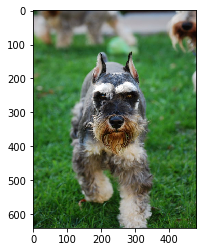

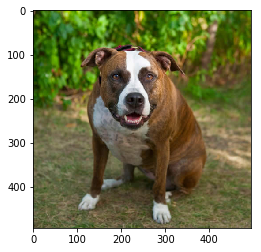

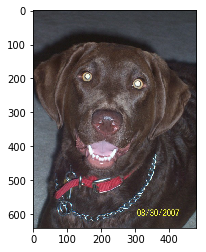

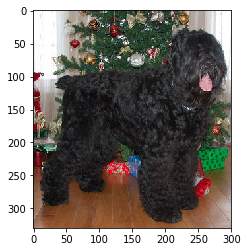

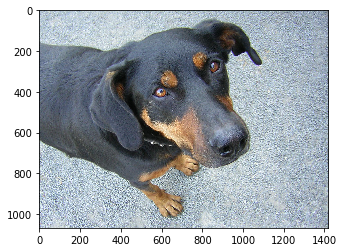

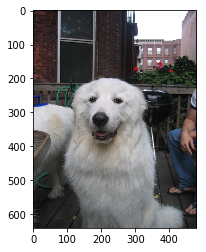

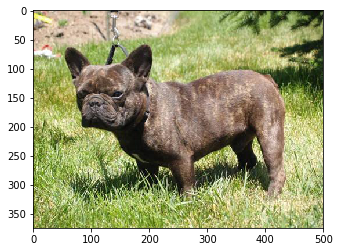

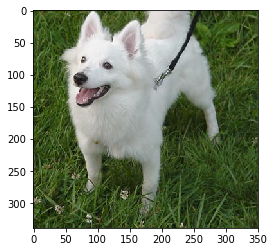

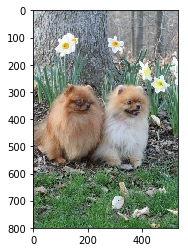

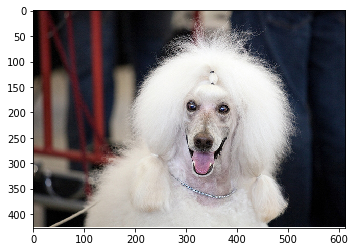

In [13]:
#import Image
indices = np.random.randint(0, len(dog_files), 10)

for idx in indices:
    image = Image.open(dog_files[idx])
    fig = plt.figure()
    plt.imshow(image)

### Look at transformed images
see if the transformations we applied (rotation, translation, etc..) are not too disturbing, it shouldn't be we cannot recognize the dogs ourselves anymore

In [23]:
# helper function to un-normalize and display an image
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

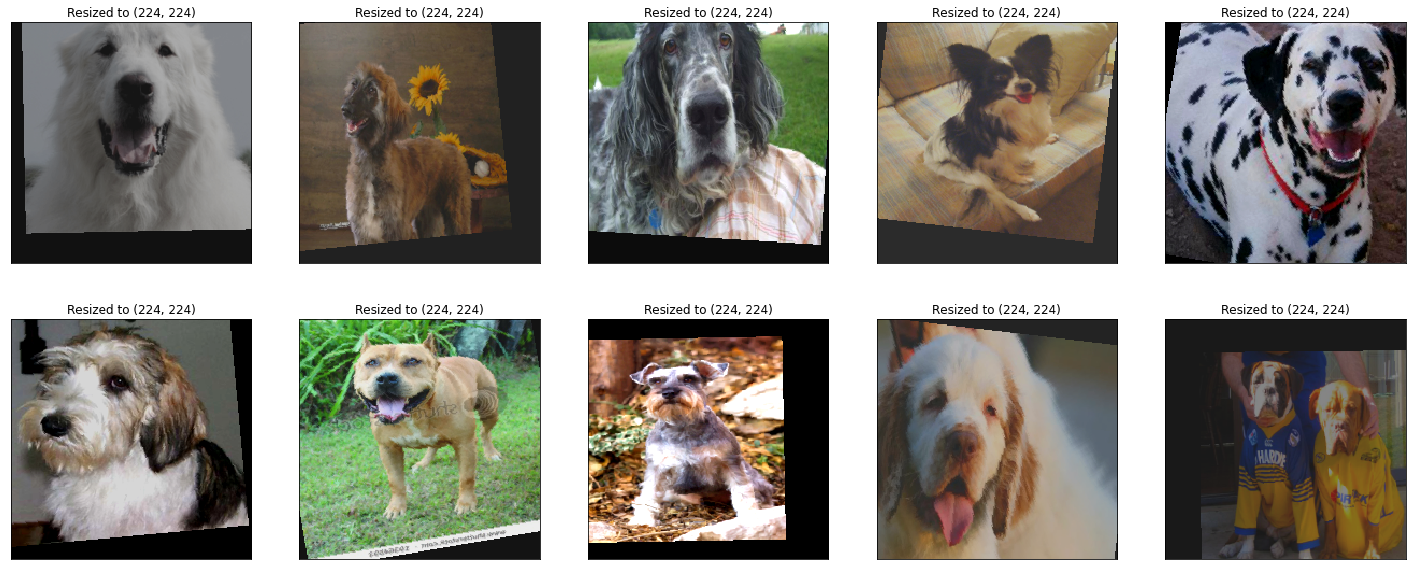

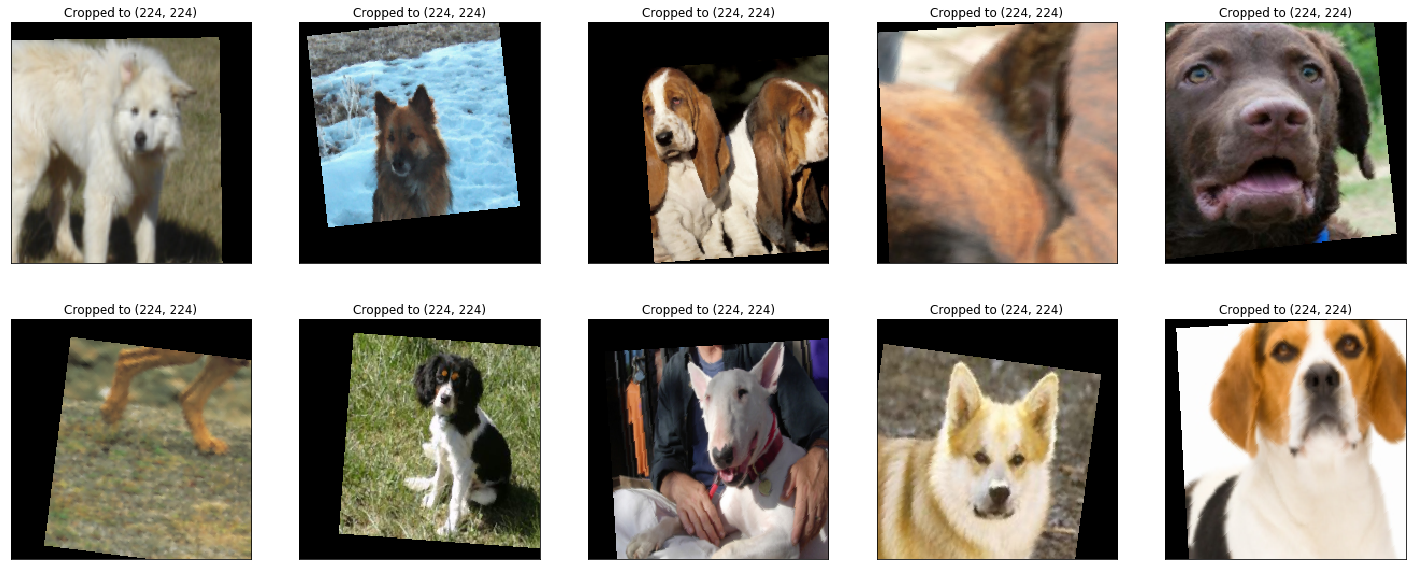

In [24]:
# obtain one batch of training images
dataiter_cr = iter(train_loader_crop)
dataiter = iter(train_loader_scratch)

images, labels = dataiter_cr.next()
images_res, labels_res = dataiter.next()


#### RESIZED IMAGES
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    # resized images
    image = un_norm(images_res[idx])
    image = image.numpy()    

    # show images
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(image)
    ax.set_title('Resized to (224, 224)')


#### CROPPED IMAGES
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    # cropped images
    image = un_norm(images[idx])
    image = image.numpy()
    #plt.imshow(image)

    # show images
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(image)
    ax.set_title('Cropped to (224, 224)')


**Motivate chosen procedure for preprocessing data**:

I had originally cropped the images to 224x224 pixel images, which is what is required for vgg16. Then I noticed that a lot of my dogs were missing their faces due to the cropping (e.g. of a lot of the pictures were quite tall compared to wide, then the top part of the picture (i.e. the head) can easily be cut off). I then decided to resize the images to 224x224 rather than cropping. 

I included some rotations, translations and colour jitter. The colour jitter might be useful because, though a lot of information is in the colours of the dogs, some breeds occur in different colours (like labradors, as also noted above) and it might be good to not depend on colour too much. Also, us humans can still recognize a german shepherd even if its colours are a big weird, so the neural network should be able to do this too.

I included horizontal flips, but no vertical flips as the vertical ones seem a bit unrealistic (maybe the pose of the dog gives information on what kind of dog it is (some dogs tend to sit up really straight, others don't), and this is harder to find when some images are upside down?

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [17]:


num_classes = 133

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(256)
        
        # fully connected layers
        self.fc1 = nn.Linear(256*7*7,  1000)
        self.fc2 = nn.Linear(1000, 500)      
        self.fc3 = nn.Linear(500, num_classes)

        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2, 2)
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.conv1_bn(self.pool(F.relu(self.conv1(x)))) #3x224x224 ---> 16x112x112
        
        x = self.conv2_bn(self.pool(F.relu(self.conv2(x)))) #16x112x112 ---> 32x56x56
        #x = F.relu(self.conv2b(x)) #64x56x56 ---> 64x56x56
        x = self.conv3_bn(self.pool(F.relu(self.conv3(x)))) #32x56x56 ---> 64x28x28
        #x = F.relu(self.conv3b(x)) #128x28x28 ---> 128x28x28
        x = self.conv4_bn(self.pool(F.relu(self.conv4(x)))) #64x28x28 ---> 128x14x14
        x = self.conv5_bn(self.pool(F.relu(self.conv5(x)))) #128x14x14 ---> 256x7x7
        
        # fully connected layers
        x = x.view(-1, 256*7*7)  
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))
        
        x = self.fc3(x)
          
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Motivation for CNN architecture__ 

To be honest, I had to try quite a few architectures before I managed to get above 10% accuracy. Initially I had constructed my model such that the first few layers were the same as those of the vgg16 model, meaning that my first convolution layer had an output size of 64. This didn't work very well and eventually I increased the number of filters more slowly. 

In the end five convolutional layers worked better than 4, and also I reduced the output size of my first fully connected layer (originally I had set it at 4000 but that did not work well). 

I also changed changed the batch-size a bunch of times, from 50 to 32 to 10 to 25. 

### Specify Loss Function and Optimizer


In [17]:
import torch.optim as optim

# select loss function
criterion_scratch = nn.CrossEntropyLoss()

# select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr = 0.001)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [27]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            output = model(data)
            
            # reset gradients
            optimizer.zero_grad()
            
            # loss and backward pass
            loss = criterion(output, target)
            loss.backward()
            
            # update weights
            optimizer.step()
            
            # keep track of loss
            train_loss = train_loss + ((1.0 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            
            valid_loss = valid_loss + ((1.0 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    # return trained model
    return model

In [18]:
# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

torch.cuda.empty_cache()

NameError: name 'train' is not defined

In [19]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

RuntimeError: cuda runtime error (35) : CUDA driver version is insufficient for CUDA runtime version at torch/csrc/cuda/Module.cpp:51

### Test the Model

Here we test out the model on some dog images, we print the test loss and accuracy.

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

I ran the model for about 90 epochs (for whatever reason it only shows the first 67 outputs, not sure why), and I got 47% accuracy, which seems very reasonable (given that random chance should only give us 0.75% accuracy (given there are 133 classes)). 

In [20]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.945854


Test Accuracy: 47% (398/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [13]:
## TODO: Specify data loaders
loaders_transfer = {'train' : train_loader, 'valid' : valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [14]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
in_old = VGG16.classifier[6].in_features
print(VGG16.classifier[6].out_features) 
print(in_old) 

# Freeze training for all "features" layers
for param in VGG16.features.parameters():
    param.requires_grad = False
    
    
VGG16.classifier[6] = nn.Linear(in_old, 133)
model_transfer = VGG16

if use_cuda:
    model_transfer = model_transfer.cuda()

1000
4096


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I took the very last layer of the VGG16 model and replaced it with a new fully connected layer with 133 outputs (as we have 133 classes). This is suitable because the dog-breed images are not that different from the images the vgg16 model was trained on (some of the classes it was predicting were dogs as well). The weights in the earlier layers were frozen (as they are used for detection of e.g. corners and lines, etc.. ) and the weights in all the fully connected layers were re-trained. I got 87% percent accuracy by just removing the last layers, which seems pretty good.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [15]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
n_epochs = 100
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer_2.pt')

# load the model that got the best validation accuracy (uncomment the line below)

Epoch: 1 	Training Loss: 4.207962 	Validation Loss: 3.016259
Validation loss decreased (inf --> 3.016259).  Saving model ...
Epoch: 2 	Training Loss: 2.490624 	Validation Loss: 1.434908
Validation loss decreased (3.016259 --> 1.434908).  Saving model ...
Epoch: 3 	Training Loss: 1.584643 	Validation Loss: 0.918020
Validation loss decreased (1.434908 --> 0.918020).  Saving model ...
Epoch: 4 	Training Loss: 1.229971 	Validation Loss: 0.735556
Validation loss decreased (0.918020 --> 0.735556).  Saving model ...
Epoch: 5 	Training Loss: 1.052936 	Validation Loss: 0.652286
Validation loss decreased (0.735556 --> 0.652286).  Saving model ...
Epoch: 6 	Training Loss: 0.967044 	Validation Loss: 0.603410
Validation loss decreased (0.652286 --> 0.603410).  Saving model ...
Epoch: 7 	Training Loss: 0.891680 	Validation Loss: 0.565055
Validation loss decreased (0.603410 --> 0.565055).  Saving model ...
Epoch: 8 	Training Loss: 0.827843 	Validation Loss: 0.551315
Validation loss decreased (0.56505

In [16]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%. My internet connection failed after about 75 epochs, but it was good enough so I didn't bother running it again.

In [23]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.458750


Test Accuracy: 87% (729/836)


### Predict Dog Breed with the Model

Here we write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [21]:
data_transfer = {'train': train_data}
np.array([item[4:].replace("_", " ") for item in data_transfer['train'].classes])

array(['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita',
       'Alaskan malamute', 'American eskimo dog', 'American foxhound',
       'American staffordshire terrier', 'American water spaniel',
       'Anatolian shepherd dog', 'Australian cattle dog',
       'Australian shepherd', 'Australian terrier', 'Basenji',
       'Basset hound', 'Beagle', 'Bearded collie', 'Beauceron',
       'Bedlington terrier', 'Belgian malinois', 'Belgian sheepdog',
       'Belgian tervuren', 'Bernese mountain dog', 'Bichon frise',
       'Black and tan coonhound', 'Black russian terrier', 'Bloodhound',
       'Bluetick coonhound', 'Border collie', 'Border terrier', 'Borzoi',
       'Boston terrier', 'Bouvier des flandres', 'Boxer', 'Boykin spaniel',
       'Briard', 'Brittany', 'Brussels griffon', 'Bull terrier', 'Bulldog',
       'Bullmastiff', 'Cairn terrier', 'Canaan dog', 'Cane corso',
       'Cardigan welsh corgi', 'Cavalier king charles spaniel',
       'Chesapeake bay retriever', 'Chihua

In [18]:
# function that takes a path to an image as input and returns the dog breed that is predicted by the model.
data_transfer = {'train': train_data}

def predict_breed_transfer(img_path, model):
    model.eval()
    # load the image and return the predicted breed
    class_names = np.array([item[4:].replace("_", " ") for item in data_transfer['train'].classes])
    
    data_transform = transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])    

    
    image = Image.open(img_path).convert('RGB')
    image = data_transform(image)
    image.unsqueeze_(0)
    
    if use_cuda:
        image = image.to('cuda')
    prediction = model(image)
    probs = F.softmax(prediction, dim=1)
    top_probs, top_idx = probs.topk(5)
    top_probs = top_probs.cpu().detach().numpy()[0]
    
    return top_probs, class_names[top_idx.cpu().numpy()[0]]

In [19]:
dog_files[642]

'/data/dog_images/train/107.Norfolk_terrier/Norfolk_terrier_07035.jpg'

In [20]:
predict_breed_transfer(dog_files[642], model_transfer)

(array([  9.93476093e-01,   2.29418953e-03,   1.57615542e-03,
          1.15969754e-03,   6.16341946e-04], dtype=float32),
 array(['Norfolk terrier', 'Norwich terrier', 'Border terrier',
        'Australian terrier', 'Silky terrier'], 
       dtype='<U34'))

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [22]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path, model_dog_detect, model_predict):
    ## handle cases for a human face, dog, and neither
    model_predict.eval()
    is_human = is_dog = False
    
    # check presence of human or dog
    if face_detector(img_path):
        is_human = True    
    
    if dog_detector(img_path, model_dog_detect):
        is_dog = True
        
    if not is_human and not is_dog:
        raise Exception('No human or dog detected in {}... supply an image with a human or a dog'.format(img_path))
    
    image = Image.open(img_path)
    probs, dog_names = predict_breed_transfer(img_path, model_predict)
    

        
    if is_human and is_dog:
        title = 'Both human and dog detected... This human/dog is predicted to be a .... {}!'.format(dog_names[0])
        fig, axs = plt.subplots(1,2, figsize = (10, 5))
        axs = axs.ravel()
    elif is_human:
        title = 'This human looks like a .....{}!'.format(dog_names[0])
        top_dog = dog_names[0].replace(' ', '_')
        dog_image_idx = np.where([top_dog in name for name in dog_files])[0][0]  
        image_dog = Image.open(dog_files[dog_image_idx])
        fig, axs = plt.subplots(1,3, figsize = (15, 5))
        axs = axs.ravel()
        axs[2].imshow(image_dog)
        axs[2].axis('off')        
    else:
        title = 'This dog is predicted to be a .... {}!'.format(dog_names[0])
        fig, axs = plt.subplots(1,2, figsize = (10, 5))
        axs = axs.ravel()
      
    xs = np.arange(1, len(probs)+1)
    axs[1].set_xticks(xs)
    axs[1].bar(xs, probs, align='center', alpha=0.5)
    axs[1].set_xticklabels(dog_names, rotation='vertical', fontsize=10)
        
    axs[0].imshow(image)
    axs[0].set_title(title)
    axs[0].axis('off')
    
    plt.tight_layout()

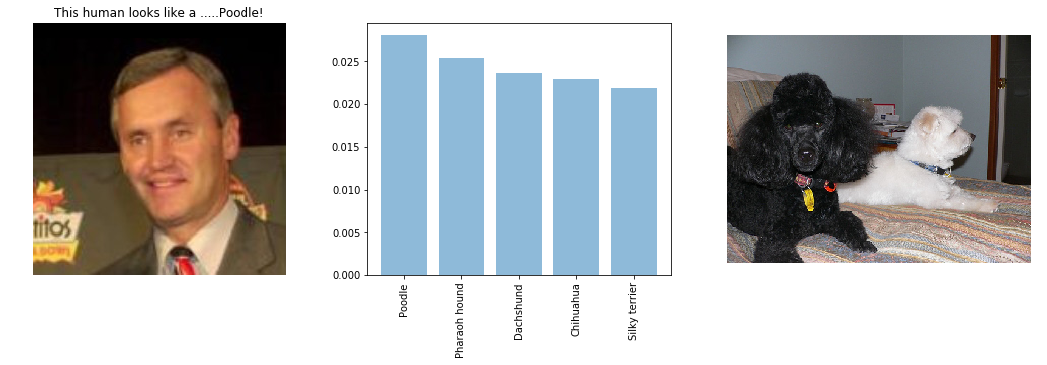

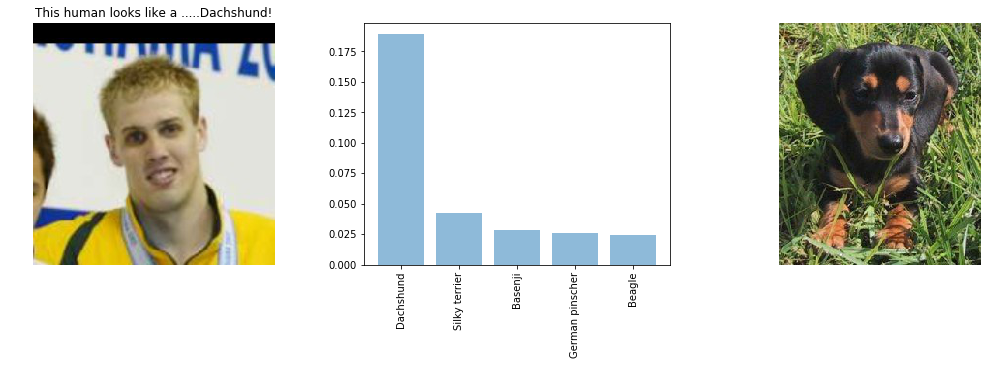

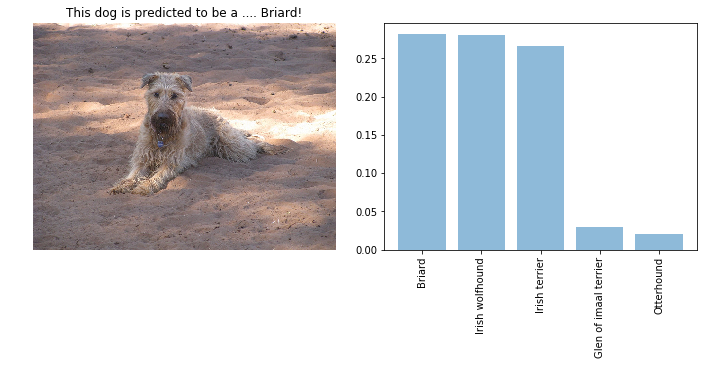

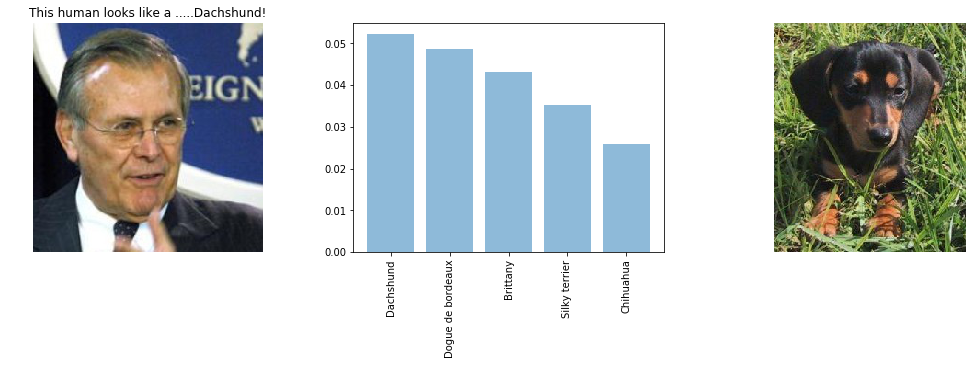

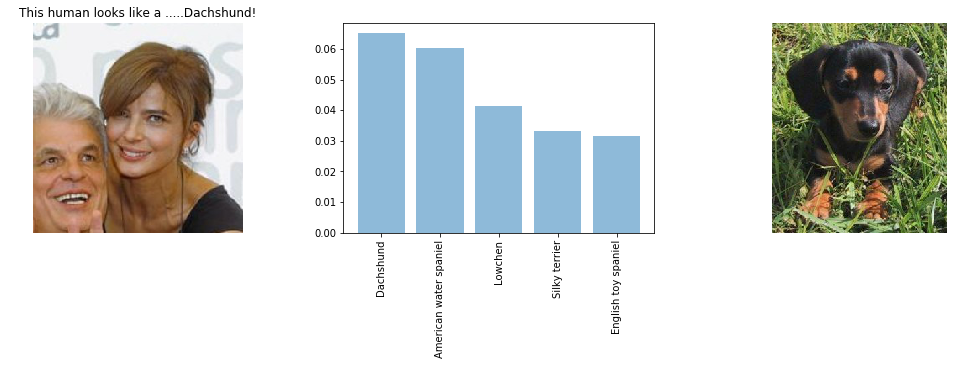

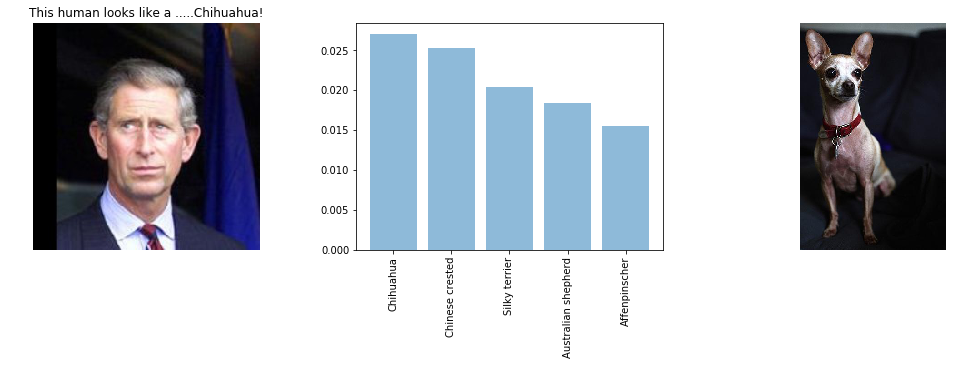

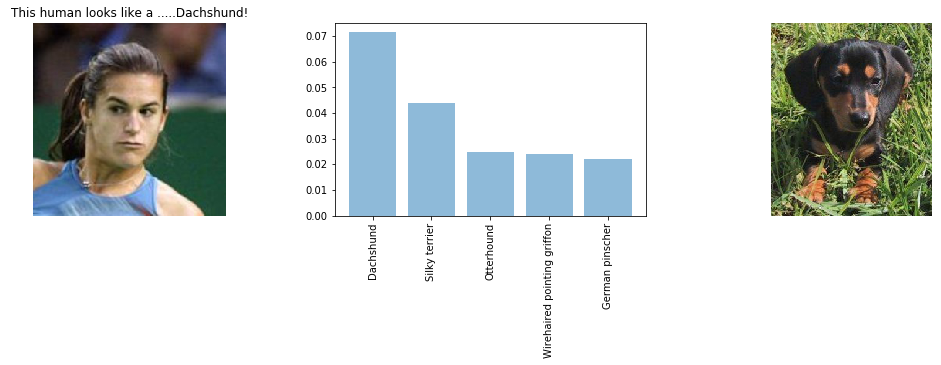

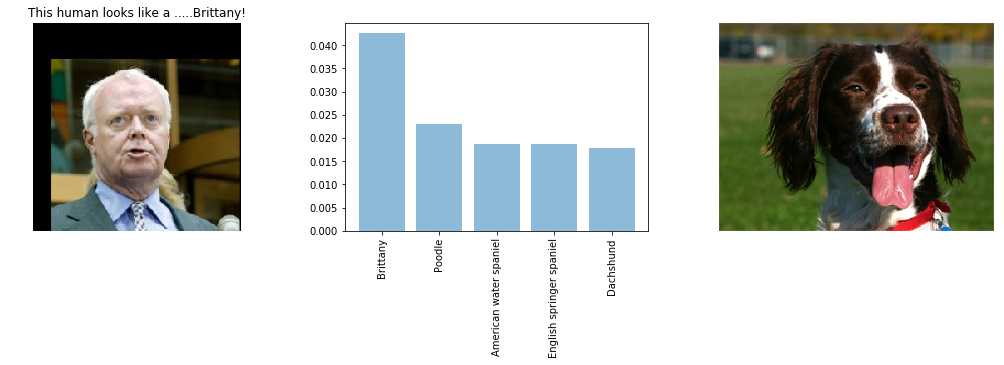

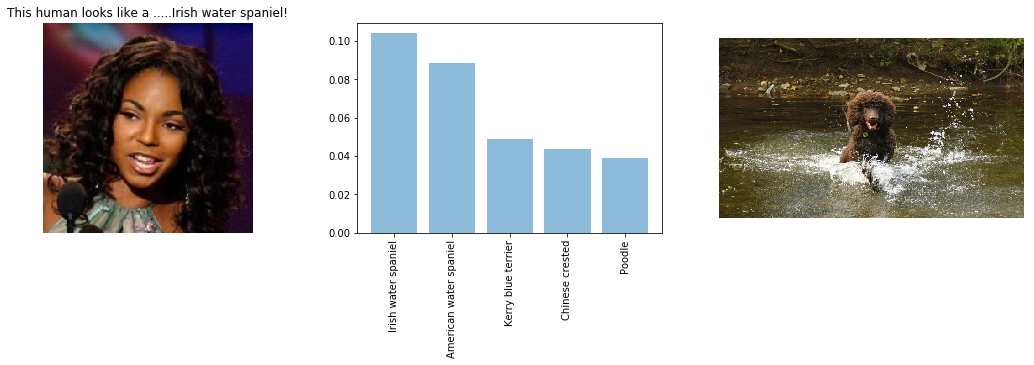

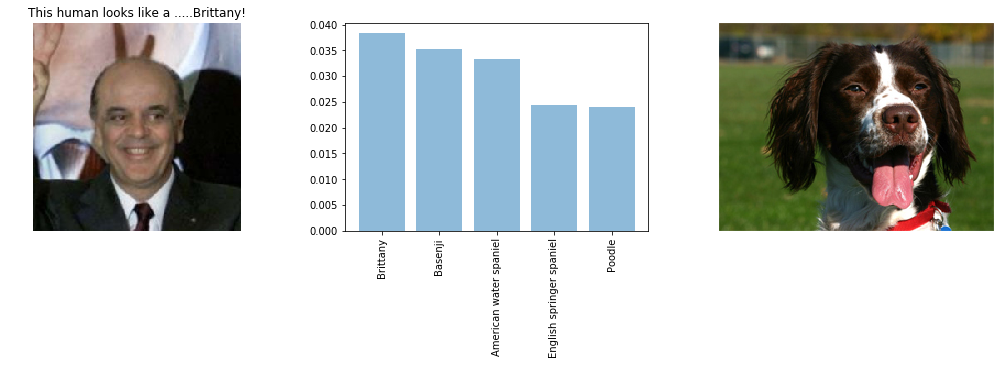

In [35]:
images = np.concatenate((human_files, dog_files))
np.random.shuffle(images)

for ii in range(10):
    run_app(images[ii], VGG16, model_transfer)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output is slightly better than I had expected. My algorithm could be improved by 
* training on more images
* training for longer
* finding better hyperparameters for e.g. the ADAM optimizer

Sometimes if I rerun the app it can give quite different outputs, I guess with humans it's just not really sure most of the time (a lot of the probabilities of the top dogs are close together)

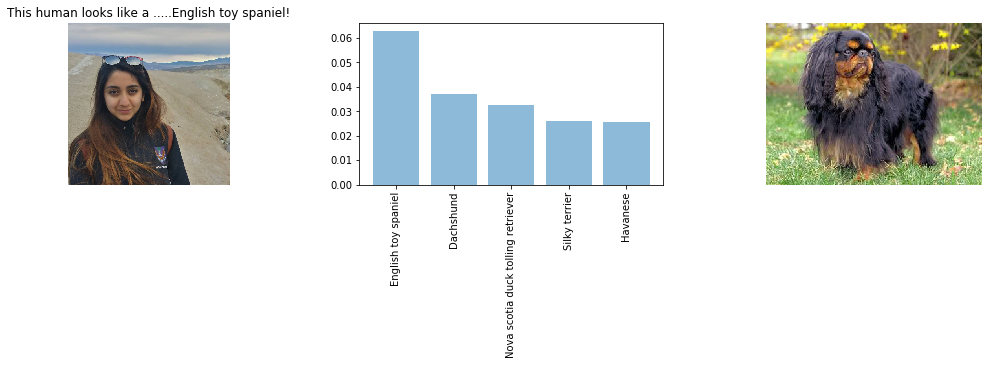

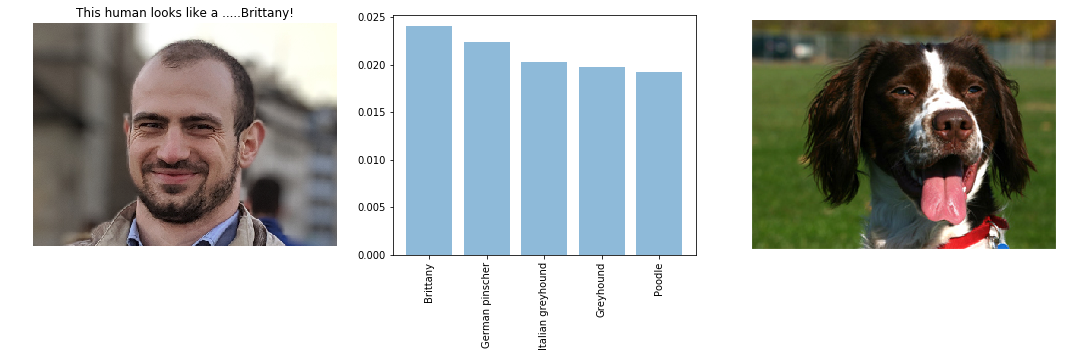

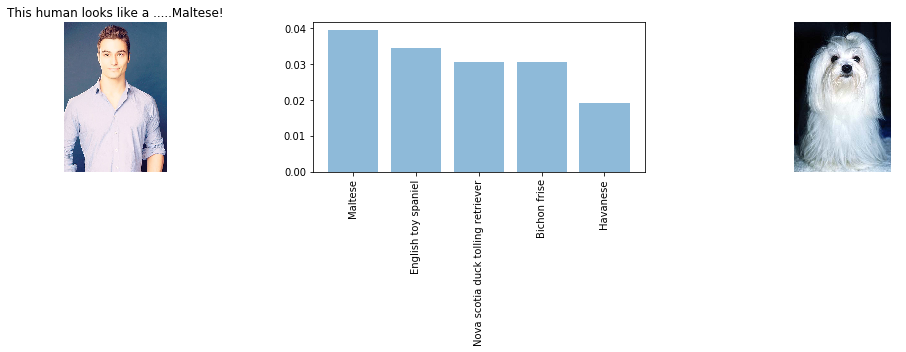

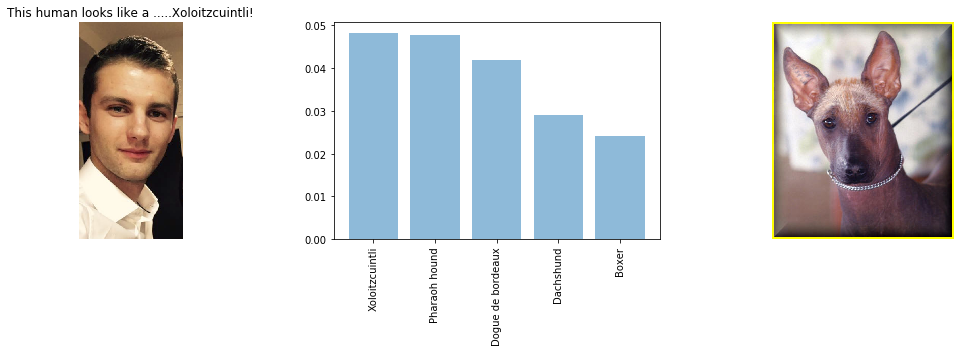

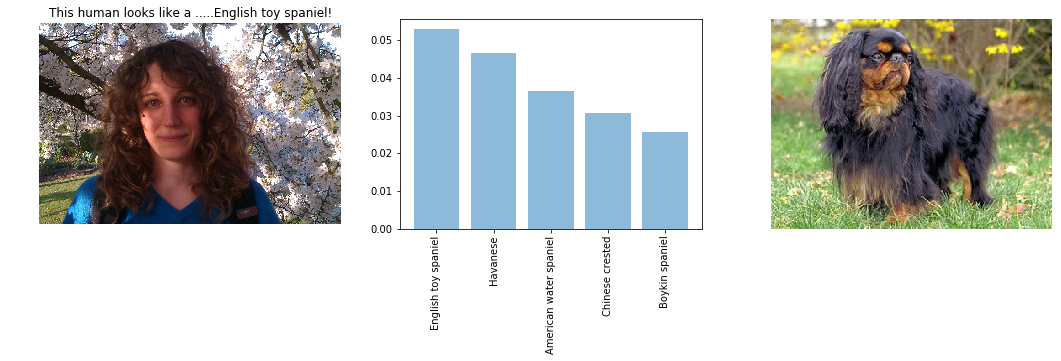

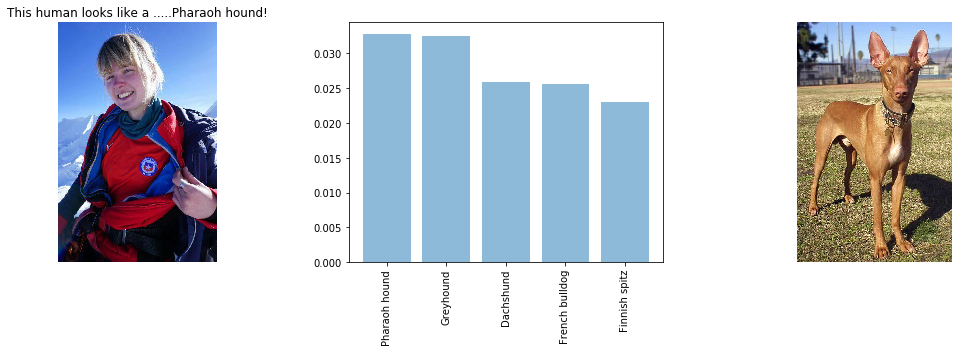

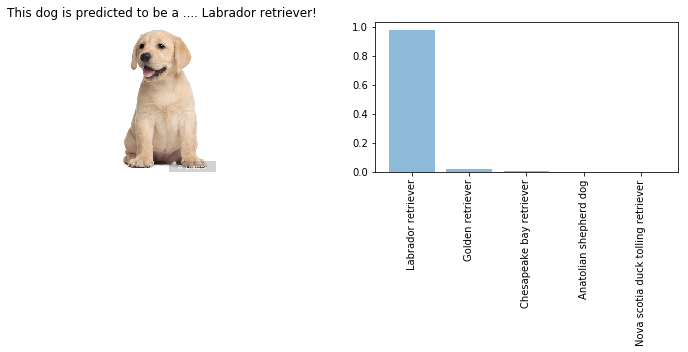

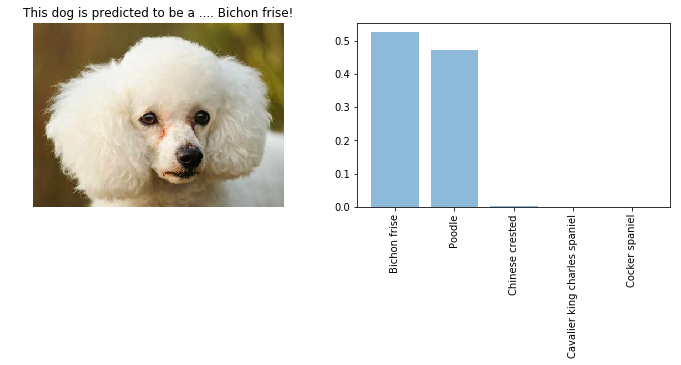

In [38]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

human_files_plot = ['aydan', 'emil.png', 'gianluca', 'antoine.png', 'hanne.jpg', 'froukje.jpg']
dog_files_plot = ['labrador.jpg', 'poodle.png']

## suggested code, below
for file in np.hstack((human_files_plot, dog_files_plot)):
    run_app(file, VGG16, model_transfer)